<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Ознакомление-с-данными" data-toc-modified-id="Ознакомление-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ознакомление с данными</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Расчет-прибыли-по-выбранным-скважинам-и-предсказаниям-модели" data-toc-modified-id="Расчет-прибыли-по-выбранным-скважинам-и-предсказаниям-модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Расчет прибыли по выбранным скважинам и предсказаниям модели</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [22]:
# для работы с таблицами
import pandas as pd

# для работы с массивами данных
import numpy as np

# для построения графиков
import matplotlib.pyplot as plt

# для разделения таблицы на выборки
from sklearn.model_selection import train_test_split

# для модели решения
from sklearn.linear_model import LinearRegression

# модуль, который позволяет автоматизировать предварительные преобразования данных перед обучением модели
from sklearn.pipeline import make_pipeline

# для стандартизации масштаба признаков
from sklearn.preprocessing import StandardScaler

# для вычисления средней квадратичной ошибки
from sklearn.metrics import mean_squared_error

# аргумент, при каждом новом вызове его состояние будет меняться на случайное- так получаем разные подвыборки
from numpy.random import RandomState

# модуль, который выводит на консоль динамически обновляемый индикатор выполнения
from tqdm import tqdm

# глобальные пареметры для случайного фиксированного сотояния модели
RANDOM = 12345
state = RandomState(RANDOM) 

### Ознакомление с данными

1) id — уникальный идентификатор скважины;  
2) f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
3) product — объём запасов в скважине (тыс. баррелей).  

* Загрузим необходимые данные:

In [23]:
zero_frame = pd.read_csv("/datasets/geo_data_0.csv")
first_frame = pd.read_csv("/datasets/geo_data_1.csv")
second_frame = pd.read_csv("/datasets/geo_data_2.csv")

* Изучим файлы с данными:

In [24]:
display('Таблица 1', zero_frame.head())
display('Таблица 2', first_frame.head())
display('Таблица 3', second_frame.head())

'Таблица 1'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'Таблица 2'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'Таблица 3'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


* Отобразим информацию по каждой таблице:

In [25]:
display('Конец таблицы 1', zero_frame.info())
display('Конец таблицы 2', first_frame.info())
display('Конец таблицы 3', second_frame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Конец таблицы 1'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Конец таблицы 2'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Конец таблицы 3'

None

* Оценим количество полных дубликатов в таблицах:

In [26]:
print('Полных дубликатов в таблице 1:', zero_frame.duplicated().sum())
print('Полных дубликатов в таблице 2:', first_frame.duplicated().sum())
print('Полных дубликатов в таблице 3:', second_frame.duplicated().sum())

Полных дубликатов в таблице 1: 0
Полных дубликатов в таблице 2: 0
Полных дубликатов в таблице 3: 0


* Оценим распределение данных по каждой таблице:

In [27]:
display('Таблица 1', zero_frame.describe())
display('Таблица 2', first_frame.describe())
display('Таблица 3', second_frame.describe())

'Таблица 1'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Таблица 2'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Таблица 3'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


* Визуализируем данные  
В силу сложности и объема анализа первоначальных данных, визуализируем их распределение на диаграмме размаха:  

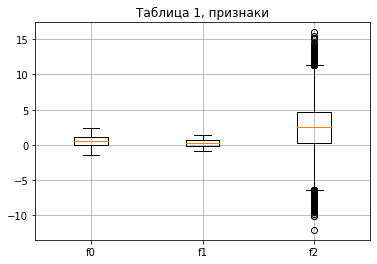

In [28]:
plt.boxplot([zero_frame.f0, zero_frame.f1, zero_frame.f2], labels=['f0', 'f1', 'f2'])
plt.grid()
plt.title('Таблица 1, признаки')
plt.show()

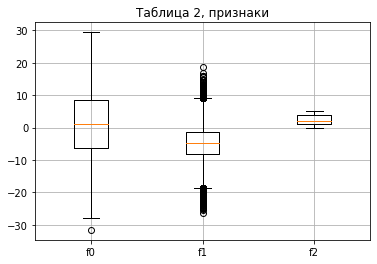

In [29]:
plt.boxplot([first_frame.f0, first_frame.f1, first_frame.f2], labels=['f0', 'f1', 'f2'])
plt.grid()
plt.title('Таблица 2, признаки')
plt.show()

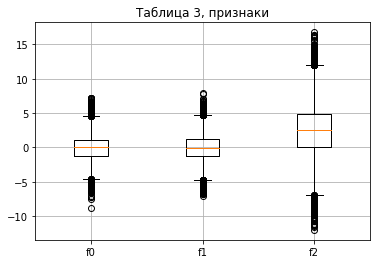

In [30]:
plt.boxplot([second_frame.f0, second_frame.f1, second_frame.f2], labels=['f0', 'f1', 'f2'])
plt.grid()
plt.title('Таблица 3, признаки')
plt.show()

**Вывод:**  
Как видно из анализа диаграмм размаха признаков f0, f1 и f2, во всех таблицах присутствуют [выбросы данных](https://www.tidydata.ru/boxplot) (отмечены на графиках черными точками), что может негативно сказаться на качестве обучения математической модели.  
Возможно, это необходимо проверить в отдельном эксперименте.

* Оценим корреляцию между признаками:

In [31]:
print('Таблица 1')
zero_frame.corr()

Таблица 1


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [32]:
print('Таблица 2')
first_frame.corr()

Таблица 2


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [33]:
print('Таблица 3')
second_frame.corr()

Таблица 3


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Как видно из данных выше, корреляция признаков в регионах различается:  
* в Таблице 1 признаки f0 и f1 отрицательно  коррелируют относительно друг друга, признак f2 положительно коррелирует с целевым признаком; 
* в Таблице 2 очень сильно коррелирует целевой признак и f2;
* в Таблице 3  коррелируют признак f2 и целевой признак.  

Так как в уловиях задачи проекта указано, что все признаки являются значимыми, мы не можем удалить столбец с признаком f2 в таблице номер 2: в данном случае интрепретируем столь высокую корреляию как сильную линейную связь между признаками, а не утечку данных.

## Обучение и проверка модели

Учитывая возможный большой объем рассматриваемых входных данных, будем использовать "конвеер".   
[подробнее о pipeline](https://www.machinelearningmastery.ru/automate-machine-learning-workflows-pipelines-python-scikit-learn/)

In [34]:
# создаем массив с названиями таблиц
array_name = ["Таблица 1",
              "Таблица 2",
              "Таблица 3"]

# создам массив с данными таблиц
array_frame = [zero_frame,
               first_frame, 
               second_frame]
# для унификации создаем словарь данных, к которому в дальнейшем будем обращаться при выводе результатов
data_dict = {'pipelines':{},'scores':{},'valid':{}, 'predictions':{}}

# попарно перебираем таблицы и их названия
for frame, name in zip(array_frame,array_name):
    # выделяем матрицу признаков, удаляем ненужный столбец id с именем строки и целевой признак
    features = frame.drop(["id","product"], axis = 1)
    # выделяем целевой признак
    target = frame["product"]
    
    # содаем конвеер- стандартизатор данных и новую модель
    new_pipeline = make_pipeline(StandardScaler(),LinearRegression())
    
    # разбиваем данные на обучающую и валидационную выборки в соотношении 75:25
    (features_train,
    features_valid,
    target_train,
    target_valid) = train_test_split(features,
                                     target,
                                     test_size = 0.25,
                                     random_state = RANDOM)
    # передаем в словарь данных валидационные выборки: кортеж и фичей [0] и таргетов [1]
    data_dict['valid'][name] = (features_valid,target_valid)
    # передаем в конвеер обучающие выборки, стандартизируем данные, обучаем модель (удобно!)
    new_pipeline.fit(features_train,target_train)
    # передаем в словарь данных стандартизатор и модель
    data_dict['pipelines'][name] = new_pipeline
    # вычисляем RMSE, записываем результат в словарь
    data_dict['scores'][name] = mean_squared_error(target_valid,
                                                   new_pipeline.predict(features_valid))**0.5
    # сохраним предсказания модели на валидационной выборке 
    data_dict['predictions'][name] = new_pipeline.predict(features_valid)

Отобразим квадратный корень из средней квадратичной ошибки (RMSE) для каждой таблицы для предсказанного значения целевого признака на валидационной выборке:

In [35]:
data_dict['scores']

{'Таблица 1': 37.5794217150813,
 'Таблица 2': 0.893099286775617,
 'Таблица 3': 40.02970873393434}

Отобразим настройки конвееров для предсказания данных:

In [36]:
data_dict['pipelines']

{'Таблица 1': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'Таблица 2': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'Таблица 3': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())])}

In [37]:
print('Средний запас предсказанного сырья в таблице 1:', data_dict['predictions']['Таблица 1'].mean())
print('Средний запас предсказанного сырья в таблице 2:', data_dict['predictions']['Таблица 2'].mean())
print('Средний запас предсказанного сырья в таблице 3:', data_dict['predictions']['Таблица 3'].mean())

Средний запас предсказанного сырья в таблице 1: 92.59256778438035
Средний запас предсказанного сырья в таблице 2: 68.728546895446
Средний запас предсказанного сырья в таблице 3: 94.96504596800489


### Вывод

* Корень из средней квадратичной ошибки меньше всего (0.89) в таблице 2, однако, в выбранном регионе модель предсказывает наименьшие средние запасы сырья на скважинах (68.73);
* Наибольшие средние запасы сырья на скважинах (94.965) представлены в регионе, описанном в таблице 3, однако в нём же наблюдается наибольший (40.03) корень из средней квадратичной ошибки;
* В таблице 1 корень из средней квадратичной ошибки составил 37.58, средние запасы сырья на скважинах составили 92.593 тысяч баррелей.

## Подготовка к расчёту прибыли

* Сохраним все ключевые значения для расчётов в отдельных переменных.

In [38]:
# Бюджет на разработку скважин в регионе — 10 млрд рублей
BUDGET_PER_REGION = 10*(10**9)
# Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
PRICE_PER_1K_BARREL = 450000
# После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.
DAMAGE_THRESHOLD =  0.025
# При разведке региона исследуют 500 точек
PRE_MAX_POINTS = 500
#  из которых с помощью машинного обучения выбирают 200 лучших для разработки.
FINAL_MAX_POINTS = 200


# посчитаем, сколько в среднем должно быть в одной скважине, чтобы не прогореть, выбирая скважины для бурения случайно
NON_DAMAGE_POINT = BUDGET_PER_REGION / PRICE_PER_1K_BARREL / FINAL_MAX_POINTS
print('Достаточный объем добычи для безубыточной разработки:', round(NON_DAMAGE_POINT, 2))

Достаточный объем добычи для безубыточной разработки: 111.11


**Вывод:**  
Данное значение достаточного объема добычи для безубыточной разработки (111.11) _существенно выше_ среднего запаса предсказанного сырья в таблицах 1, 2, 3 (92.59, 68.73, 94.965), следоваельно, мы _не можем_ выбирать в заданных областях вышки случайно. Необходимо задействовать предсказания модели.

### Расчет прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [39]:
# на вход подаем целевой признак валидационной выборки и предсказанные значения признака для валидационной выборки
def income(true_target, pred_target):
    # переведем массив в Series для доп. функционала по обработке
    # отсортируем значения по убыванию
    # возьмем первые 200 (в данном случае) строк
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:FINAL_MAX_POINTS]
    # синхронизируем списки целевого признака валидационной выборки по сортированным индексам предсказанных значений
    true_target_sort = (true_target.reset_index(drop = True)[sort_Series.index])
    # вычислим сумму для ТОПа скважин по целевому признакку
    sum_true = true_target_sort.sum() 
    # полученную сумму тысяч баррелей сырья умножим на цену за тысячу баррелей и вычтем бюджет на область
    return ((sum_true * PRICE_PER_1K_BARREL) - BUDGET_PER_REGION)

In [40]:
print("Прибыль с лучших 200 скважин в Таблице 1:", round(income(data_dict['valid']['Таблица 1'][1],
                                                               data_dict['predictions']['Таблица 1']), 2))
print("Прибыль с лучших 200 скважин в Таблице 2:", round(income(data_dict['valid']['Таблица 2'][1],
                                                               data_dict['predictions']['Таблица 2']), 2))
print("Прибыль с лучших 200 скважин в Таблице 3:", round(income(data_dict['valid']['Таблица 3'][1],
                                                               data_dict['predictions']['Таблица 3']), 2))

Прибыль с лучших 200 скважин в Таблице 1: 3320826043.14
Прибыль с лучших 200 скважин в Таблице 2: 2415086696.68
Прибыль с лучших 200 скважин в Таблице 3: 2710349963.6


Таким образом, выбирая ТОП-200 скважин из предсказанных значений модели и расчитывая прибыли по истинным значениям запасов сырья для этих скважин, мы расчитали прибыль по выбранным скважинам и предсказаниям модели.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков (убыток — это отрицательная прибыль).  

In [41]:
# фукция расчета доверительного интервала, 
# на вход подаем целевой признак валидационной выборки и предсказанные значения признака для валидационной выборки
def confidence_interval(true_target,pred_target):
    # создадим список для интервалов
    samples = []
    # # tqdm - модуль, который выводит на консоль динамически обновляемый индикатор выполнения, Bootstrap с 1000 выборок
    for i in tqdm(range(1000)):
        # соберем произвольные выборки функцией sample
        # где n - число включений (размер выборки), replace=True возвращает элементы в изначальную выборку
        # преобразуем тип данных в Series для удобства обработки
        sample = pd.Series(pred_target).sample(n = PRE_MAX_POINTS, replace=True, random_state=state)
        # записываем в список полученную прибыль, функция "income" описана ранее
        samples.append(income(true_target,sample))
    # преобразуем тип данных в Series для удобства обработки
    samples = pd.Series(samples)
    print('Среднее значение дохода для выбранного региона:', round(samples.mean(), 2))
    # суммируем число убыточных по прибыли выборок, делим на общее число выборок, переводим в проценты
    print('Процент убыточных выборок:', samples.apply(lambda x: x < 0).sum()/len(samples)*100,"%")
    # вычисляем границы доверительного интервала
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

In [42]:
print("95% доверительный итервал для Таблицы 1 лежит между:",
      confidence_interval(data_dict['valid']['Таблица 1'][1], data_dict['predictions']['Таблица 1']))
print()
print("95% Доверительный итервал для Таблицы 2 лежит между:",
      confidence_interval(data_dict['valid']['Таблица 2'][1], data_dict['predictions']['Таблица 2']))
print()
print("95% Доверительный итервал для Таблицы 3 лежит между:",
      confidence_interval(data_dict['valid']['Таблица 3'][1], data_dict['predictions']['Таблица 3']))

100%|██████████| 1000/1000 [00:01<00:00, 674.19it/s]


Среднее значение дохода для выбранного региона: 396164984.8
Процент убыточных выборок: 6.9 %
95% доверительный итервал для Таблицы 1 лежит между: (-111215545.89, 909766941.55)



100%|██████████| 1000/1000 [00:01<00:00, 672.79it/s]


Среднее значение дохода для выбранного региона: 461155817.28
Процент убыточных выборок: 0.7000000000000001 %
95% Доверительный итервал для Таблицы 2 лежит между: (78050810.75, 862952060.26)



100%|██████████| 1000/1000 [00:01<00:00, 671.52it/s]

Среднее значение дохода для выбранного региона: 392950475.17
Процент убыточных выборок: 6.5 %
95% Доверительный итервал для Таблицы 3 лежит между: (-112227625.38, 934562914.55)


## Вывод

Исходя из задач проекта, учета всех значений матрицы признаков и выделения всех признаков модели в качестве важных, наиболее выгодным для разработки представляется область (регион), описанный в Таблице 2:  
* Среднее значение дохода для выбранного региона с лучших 500 случайно выбранных скважин: 461 155 817.28
* Процент убыточных выборок: 0.7000000000000001 %
* 95% Доверительный итервал лежит между: (78 050 810.75, 862 952 060.26)
* Прибыль с гарантированно лучших 200 скважин: 2 415 086 696.68
* Корень из средней квадратичной ошибки (RMSE): 0.893

При этом, достаточный объем добычи для безубыточной разработки: 111.11 тыс. баррелей.  



